# Práctica 2: Modelo cinemático inverso de un  y planteamiento de trayectoria

## Objetivo

El objetivo de esta práctica es que el alumno comprenda, interprete y modifique la información básica de los formatos de Universal Robot Description File (URDF).


### Metas 

- Que el alumno aplique un modelo cinemático inverso para calcular una trayectoria a partir de una posición actual hacia una posición final
- Que el alumno grafique y analice los resultados del modelo
- Que el alumno configure un repositorio en línea e incluya en éste su práctica

### Contribución al perfil del egresado

La siguiente práctica contribuye en los siguientes puntos al perfil del egresado:

#### Aptitudes y habilidades

- Para modelar, simular e interpretar el comportamiento de los sistemas mecatrónicos.
- Para diseñar, construir, operar y mantener los sistemas mecatrónicos y sus componentes.

#### Actitudes

- Tener confianza en su preparación académica.
- Comprometido con su actualización, superación y competencia profesional.

#### De tipo social

- Promover el cambio en la mentalidad frente a la competitividad internacional.

## Rúbrica de evaluación

La evaluación de la práctica contará de los siguientes puntos y se evaluará con los siguientes criterios:

| Elemento | Porcentaje |
| ------:| ----------- |
| **Cuestionario previo** | 15% | 
| **Desarrollo** | 35% |
| **Análisis de resultados**  | 35% |
| **Conclusiones** | 15% |

| Elemento | Malo | Regular | Bueno |
| ------:| ------ | --------| ------|
| **Cuestionario previo** | El trabajo no contiene cuestionario previo o todas las preguntas son incorrectas (0%)| Al menos la mitad de las preguntas son correctas (8%) |  Todas las preguntas son correctas (15%) |
| **Desarrollo** | El trabajo no contiene desarrollo o su planteamiento no concuerda con lo deseado (0%) | El desarrollo está mal planteado o no llega a los resultados esperados (10%) | El desarrollo tiene un planteamiento adecuado y llega a los resultados esperados (35%) |
| **Análisis de resultados**  | El trabajo no contiene análisis de resultados o la información no se está interpretando correctamente (0%) | La interpretación de los resultados es parcial o desorganizada (10%) | Realiza un correcto análisis de los resultados de forma organizada   (35%) |
| **Conclusiones** | El trabajo no contiene conclusiones o no hacen referencia al trabajo desarrollado y los objetivos planteados (0%) | La redacción de las conclusiones es desorganizada o confusa (8%) | Las conclusiones del trabajo son claras y hacen referencia al trabajo desarrollado y los objetivos planteados (15%) | 



## Introducción

### Transformaciones homogéneas
Las transformaciones homogéneas permiten hacer el planteamiento del modelo cinemático de un robot, considerando las posiciones y orientaciones de las juntas del robot respecto al sistema de referencia de una junta anterior

Este planteamiento es el **modelo de cinemática directa**, que nos permite obtener la posición y velocidad del efector final de un manipulador en términos de los valores de la posición y velocidad de sus juntas (espacio de trabajo)

A través de este modelo se puede obtener el **modelo de cinemática inversa**, que permite obtener la velocidad de las juntas de un robot a partir de la velocidad deseada del efector final.

### Planteamiento de una trayectoria
Si se conoce el punto inicial y final de una trayectoria deseada, se pueden obtener los puntos intermedios de la trayectoria. La forma más fácil de realizar esta interpolación es a través de un spline. El orden del spline permitirá controlar las condiciones inicial y final de la posición, velocidad ó aceleración que tendrá el efector final durante el trayecto. 

Juntando la interpolación de la trayectoria y el modelo de la cinemática inversa, se pueden obtener todos los puntos intermedios de la trayectoria que deben seguir las juntas del robot para que el efector final siga una trayectoria.

## Cuestionario previo

Responder de forma breve las siguientes preguntas:

- ¿Que son las transformaciones homogéneas?
- ¿Que nos permite obtener el modelo de cinemática inversa de un manipulador?
- ¿De que formas se puede interpolar la trayectoria de un efector final entre dos puntos?
- ¿Qué es git?
- ¿Qué es github?

En caso de integrar imagenes, colocarlas en la carpeta *"imagenes"*

## Desarrollo

### 1. Planteamiento de la cinemática directa
En esta primera parte, se crearán las transformaciones homogéneas y el modelo de cinemática directa de un robot RRR, incluyendo la matriz del Jacobiano. Se recomienda usar **Sympy** para el planteamiento de las expresiones. 
Un diagrama del robot se muestra en la imagen:

<img src="imagenes/P2_IM1.png" alt = "Robot RRR" width="300" height="300" display= "block"/>



In [21]:
#!/usr/bin/env python3
import rclpy
from rclpy.node import Node
from std_msgs.msg import String
from sympy import *
import matplotlib
import matplotlib.pyplot as plt
import numpy

class TrayectoryGenerator():
    def __init__(self, dim = (0.3, 0.3, 0.3), base_dim = (0, 0, 0.1), base_rot = (pi/2, 0, 0)):
        # Parámetros de dimensiones
        self.dim = dim
        self.base_dim = base_dim
        self.base_rot = base_rot
        # Variables para cinemática directa
        self.theta_O_1 = Symbol('theta_O_1')
        self.theta_1_2 = Symbol('theta_1_2')
        self.theta_2_3 = Symbol('theta_2_3')
        # Transformaciones homogéneas
        print("TRANSFORMACIONES HOMOGÉNEAS \n")
        T_O_O = self.trans_homo(self.base_dim[0], self.base_dim[1], self.base_dim[2], 
                                self.base_rot[0], self.base_rot[1], self.base_rot[2])
        print("T_0_0: ", str(T_O_O))
        
        T_O_1 = self.trans_homo(0, 0, 0, 
                                0, 0, self.theta_O_1)
        print("T_0_1: ", str(T_O_1))
        
        T_1_2 = self.trans_homo(self.dim[0], 0, 0, 
                                0, 0, self.theta_1_2)
        print("T_1_2: ", str(T_1_2))
        
        T_2_3 = self.trans_homo(self.dim[1], 0, 0, 
                                0, 0, self.theta_2_3)
        print("T_2_3: ", str(T_2_3))
        
        T_3_P = self.trans_homo(self.dim[2], 0, 0, 
                                0, 0, 0)
        print("T_3_P: ", str(T_3_P))
        
        T_O_P = simplify(T_O_O*T_O_1 * T_1_2 * T_2_3 * T_3_P)
        print("T_0_P: ", str(T_O_P))
        print("\n")
        # Cinemática directa (posición final)
        print("CINEMATICA DIRECTA\n")
        print(str(T_O_P[0, 3]), str(T_O_P[1, 3]), str(T_O_P[2, 3]))

        # Jacobiano
        self.xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], 
                              self.theta_O_1 + self.theta_1_2 + self.theta_2_3])
        self.J = Matrix.hstack(diff(self.xi_O_P, self.theta_O_1), 
                               diff(self.xi_O_P, self.theta_1_2), 
                               diff(self.xi_O_P, self.theta_2_3))
        self.J_inv = self.J.inv()
        print("\n")
        # Imprimir el jacobiano
        print("JACOBIANO \n")
        print( str(self.J))

    def trans_homo(self, x, y, z, gamma, beta, alpha):
        T = Matrix([[cos(alpha)*cos(beta), -sin(alpha)*cos(gamma)+sin(beta)*sin(gamma)*cos(alpha), 
                     sin(alpha)*sin(gamma)+sin(beta)*cos(alpha)*cos(gamma), x],
                    [sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), 
                     sin(alpha)*sin(beta)*cos(gamma)-sin(gamma)*cos(alpha), y],
                    [-sin(beta), sin(gamma)*cos(beta), cos(beta)*cos(gamma), z],
                    [0, 0, 0, 1]])
        return T 

def main():
    trayectory_gen = TrayectoryGenerator()

if __name__ == "__main__":
    main()


TRANSFORMACIONES HOMOGÉNEAS 

T_0_0:  Matrix([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0.100000000000000], [0, 0, 0, 1]])
T_0_1:  Matrix([[cos(theta_O_1), -sin(theta_O_1), 0, 0], [sin(theta_O_1), cos(theta_O_1), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
T_1_2:  Matrix([[cos(theta_1_2), -sin(theta_1_2), 0, 0.300000000000000], [sin(theta_1_2), cos(theta_1_2), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
T_2_3:  Matrix([[cos(theta_2_3), -sin(theta_2_3), 0, 0.300000000000000], [sin(theta_2_3), cos(theta_2_3), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
T_3_P:  Matrix([[1, 0, 0, 0.300000000000000], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
T_0_P:  Matrix([[cos(theta_1_2 + theta_2_3 + theta_O_1), -sin(theta_1_2 + theta_2_3 + theta_O_1), 0, 0.3*cos(theta_O_1) + 0.3*cos(theta_1_2 + theta_O_1) + 0.3*cos(theta_1_2 + theta_2_3 + theta_O_1)], [0, 0, -1, 0], [sin(theta_1_2 + theta_2_3 + theta_O_1), cos(theta_1_2 + theta_2_3 + theta_O_1), 0, 0.3*sin(theta_O_1) + 0.3*sin(theta_1_2 + theta_O_1) + 0.3*sin(theta_1_2 + theta_2_

### 2. Cinemática inversa
A partir del modelo de la cinemática directa, obtener la expresión de la cinemática inversa, que relacione las velocidades de las juntas del robot con la velocidad del efector final. Ya que el modelo de cinemática inversa sólo permite obtener velocidades, obtener también expresiones que permitan obtener la posición de las juntas y sus aceleraciones

In [53]:
#!/usr/bin/env python3
import rclpy
from rclpy.node import Node
from std_msgs.msg import String
from sympy import *
#from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols

import matplotlib
import matplotlib.pyplot as plt
import numpy

class TrayectoryGenerator():
  def __init__(self, dim = (0.3, 0.3, 0.3), base_dim = (0, 0, 0.1), base_rot = (pi/2, 0, 0)):
    #Parámetros de dimensiones
    self.dim = dim
    self.base_dim = base_dim
    self.base_rot = base_rot
    #Variables para cinemática directa
    self.theta_O_1 = Symbol('theta_O_1')
    self.theta_1_2 = Symbol('theta_1_2')
    self.theta_2_3 = Symbol('theta_2_3')
    #Grados de libertad
    self.x_O_P = Symbol('x_O_P')
    self.z_O_P = Symbol('y_O_P')
    self.theta_O_P = Symbol('theta_O_P')
    #Velocidades
    self.x_O_P_dot = Symbol('x_O_P_dot')
    self.z_O_P_dot = Symbol('y_O_P_dot')
    self.theta_O_P_dot = Symbol('theta_O_P_dot')
    #Transformaciones homogéneas
    T_O_O = self.trans_homo(self.base_dim[0], self.base_dim[1], self.base_dim[2], 
                            self.base_rot[0], self.base_rot[1], self.base_rot[2])
    
    T_O_1 = self.trans_homo(0, 0, 0, 
                            0, 0, self.theta_O_1)
    T_1_2 = self.trans_homo(self.dim[0], 0, 0, 
                            0, 0, self.theta_1_2)
    T_2_3 = self.trans_homo(self.dim[1], 0, 0, 
                            0, 0, self.theta_2_3)
    T_3_P = self.trans_homo(self.dim[2], 0, 0, 
                            0, 0, 0)
    T_O_P = simplify(T_O_O*T_O_1 * T_1_2 * T_2_3 * T_3_P)

    self.xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], 
                          self.theta_O_1 + self.theta_1_2 + self.theta_2_3])
    self.J = Matrix.hstack(diff(self.xi_O_P, self.theta_O_1), 
                           diff(self.xi_O_P, self.theta_1_2), 
                           diff(self.xi_O_P, self.theta_2_3))
    
    print("CINAMTICA INVERSA")
    self.J_inv = self.J.inv()
    print(self.J_inv)
    #print(self.J)
    
  def trans_homo(self, x, y, z, gamma, beta, alpha):
    T = Matrix([[cos(alpha)*cos(beta), -sin(alpha)*cos(gamma)+sin(beta)*sin(gamma)*cos(alpha), sin(alpha)*sin(gamma)+sin(beta)*cos(alpha)*cos(gamma), x],
         [sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-sin(gamma)*cos(alpha), y],
        [-sin(beta), sin(gamma)*cos(beta), cos(beta)*cos(gamma), z],[0, 0, 0, 1]])
    return T 

def main():
  trayectory_gen = TrayectoryGenerator()

if __name__ == "__main__":
  main()

CINAMTICA INVERSA
Matrix([[3.33333333333333*cos(theta_1_2 + theta_O_1)/(-1.0*sin(theta_O_1)*cos(theta_1_2 + theta_O_1) + 1.0*sin(theta_1_2 + theta_O_1)*cos(theta_O_1)), 3.33333333333333*sin(theta_1_2 + theta_O_1)/(-1.0*sin(theta_O_1)*cos(theta_1_2 + theta_O_1) + 1.0*sin(theta_1_2 + theta_O_1)*cos(theta_O_1)), (-1.0*sin(theta_1_2 + theta_O_1)*cos(theta_1_2 + theta_2_3 + theta_O_1) + 1.0*sin(theta_1_2 + theta_2_3 + theta_O_1)*cos(theta_1_2 + theta_O_1))/(-1.0*sin(theta_O_1)*cos(theta_1_2 + theta_O_1) + 1.0*sin(theta_1_2 + theta_O_1)*cos(theta_O_1))], [(-3.33333333333333*cos(theta_O_1) - 3.33333333333333*cos(theta_1_2 + theta_O_1))/(-1.0*sin(theta_O_1)*cos(theta_1_2 + theta_O_1) + 1.0*sin(theta_1_2 + theta_O_1)*cos(theta_O_1)), (-3.33333333333333*sin(theta_O_1) - 3.33333333333333*sin(theta_1_2 + theta_O_1))/(-1.0*sin(theta_O_1)*cos(theta_1_2 + theta_O_1) + 1.0*sin(theta_1_2 + theta_O_1)*cos(theta_O_1)), (1.0*sin(theta_O_1)*cos(theta_1_2 + theta_2_3 + theta_O_1) + 1.0*sin(theta_1_2 + theta

### 3. Planteamiento de la trayectoria

En esta segunda parte, se planteará el código que permita definir los puntos intermedios de una trayectoria, la cual debe tener velocidades y aceleraciones nulas al inicio y al final. Se deben incluir también las gráficas de la posición, velocidad y aceleración del efector final. 

Calcular la trayectoria considerando de forma general tiempo de duración, puntos inicial y final, y con una tasa de muestreo de 30 muestras por segundo. 

[{a_0: 0, a_1: 0, a_2: 0, a_3: 10/27, a_4: -5/27, a_5: 2/81}]


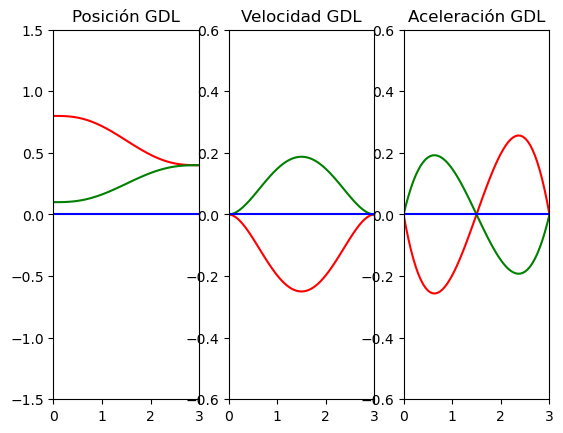

In [57]:
#!/usr/bin/env python3
import rclpy
from rclpy.node import Node
from std_msgs.msg import String
from sympy import *
#from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols

import matplotlib
import matplotlib.pyplot as plt
import numpy

class TrayectoryGenerator():
  def __init__(self, dim = (0.3, 0.3, 0.3), base_dim = (0, 0, 0.1), base_rot = (pi/2, 0, 0)):
    #Parámetros de dimensiones
    self.dim = dim
    self.base_dim = base_dim
    self.base_rot = base_rot
    #Variables para cinemática directa
    self.theta_O_1 = Symbol('theta_O_1')
    self.theta_1_2 = Symbol('theta_1_2')
    self.theta_2_3 = Symbol('theta_2_3')
    #Grados de libertad
    self.x_O_P = Symbol('x_O_P')
    self.z_O_P = Symbol('y_O_P')
    self.theta_O_P = Symbol('theta_O_P')
    #Velocidades
    self.x_O_P_dot = Symbol('x_O_P_dot')
    self.z_O_P_dot = Symbol('y_O_P_dot')
    self.theta_O_P_dot = Symbol('theta_O_P_dot')
    #Transformaciones homogéneas
    T_O_O = self.trans_homo(self.base_dim[0], self.base_dim[1], self.base_dim[2], 
                            self.base_rot[0], self.base_rot[1], self.base_rot[2])
    
    T_O_1 = self.trans_homo(0, 0, 0, 
                            0, 0, self.theta_O_1)
    T_1_2 = self.trans_homo(self.dim[0], 0, 0, 
                            0, 0, self.theta_1_2)
    T_2_3 = self.trans_homo(self.dim[1], 0, 0, 
                            0, 0, self.theta_2_3)
    T_3_P = self.trans_homo(self.dim[2], 0, 0, 
                            0, 0, 0)
    T_O_P = simplify(T_O_O*T_O_1 * T_1_2 * T_2_3 * T_3_P)
    self.xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], 
                          self.theta_O_1 + self.theta_1_2 + self.theta_2_3])
    self.J = Matrix.hstack(diff(self.xi_O_P, self.theta_O_1), 
                           diff(self.xi_O_P, self.theta_1_2), 
                           diff(self.xi_O_P, self.theta_2_3))
    self.J_inv = self.J.inv()
    #print(self.J)
  def trans_homo(self, x, y, z, gamma, beta, alpha):
    T = Matrix([[cos(alpha)*cos(beta), -sin(alpha)*cos(gamma)+sin(beta)*sin(gamma)*cos(alpha), sin(alpha)*sin(gamma)+sin(beta)*cos(alpha)*cos(gamma), x],
         [sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-sin(gamma)*cos(alpha), y],
        [-sin(beta), sin(gamma)*cos(beta), cos(beta)*cos(gamma), z],[0, 0, 0, 1]])
    return T 
  def polinomial_trayectory_generator(self, frec = 20, time = (0, 3), gdl_in = (0.8, 0.1, 0), gdl_fn = (0.4, 0.4, 0)):
    self.frec = frec
    a_0, a_1, a_2, a_3, a_4, a_5, t = symbols('a_0 a_1 a_2 a_3 a_4 a_5 t')
    lam = a_0 + a_1*t + a_2*(t**2) + a_3*(t**3) + a_4*(t**4) + a_5*(t**5)
    lam_dot = diff(lam, t)
    lam_dot_dot = diff(lam_dot, t)
    terms = solve([
      lam.subs(t, time[0]) - 0,
      lam.subs(t, time[1]) - 1,
      lam_dot.subs(t, time[0]) - 0,
      lam_dot.subs(t, time[1]) - 0,
      lam_dot_dot.subs(t, time[0]) - 0,
      lam_dot_dot.subs(t, time[1]) - 0
    ], [a_0, a_1, a_2, a_3, a_4, a_5], dict = True)
    print(terms)
    #Lambda con valores sustituidos
    lam_s = lam.subs(terms[0])
    lam_s_dot = lam_dot.subs(terms[0])
    lam_s_dot_dot = lam_dot_dot.subs(terms[0])
    samples = frec * (time[1] - time[0]) + 1
    dt = 1.0 / frec

    #Creando arreglos para guardar las posiciones de los GDL
    gdl = []
    gdl_dot = []
    gdl_dot_dot = []
    for a in range(samples):
      gdl.append((gdl_in[0] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                  gdl_in[1] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                  gdl_in[2] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot.append((lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot_dot.append((lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
    #Obteniendo posición inicial del ws
    self.xi_desp = self.xi_O_P - Matrix([gdl_in[0], 
                                        gdl_in[1], 
                                        gdl_in[2]])
    """print("Calculando posiciones iniciales")
    q_in = solve([self.xi_desp],
                  [self.theta_O_1, 
                   self.theta_1_2, 
                   self.theta_2_3])
    print("Posiciones iniciales:")
    print(q_in)
    q_in_def = 0
    for i in q_in:
      if i[0]>0:
        q_in_def = i
        break
    """
    q_in_def = (0.585685543457151, 
                -1.17137108691430, 
                0.585685543457151)
    #Calculando velocidad inicial
    self.xi_O_P_dot = Matrix([self.x_O_P_dot,
                              self.z_O_P_dot,
                              self.theta_O_P_dot])
    self.q_O_P_dot = self.J_inv * self.xi_O_P_dot
    #Arreglos para guardar las posiciones del ws
    ws = []
    ws_dot = []
    ws_dot_dot = []
    #Agregando posición inicial
    ws.append(q_in_def)
    #Agregando velocidad inicial
    q_dot_in = self.q_O_P_dot.subs({
      self.x_O_P_dot:     gdl_dot[0][0],
      self.z_O_P_dot:     gdl_dot[0][1],
      self.theta_O_P_dot: gdl_dot[0][2],
      self.theta_O_1: ws[0][0],
      self.theta_1_2: ws[0][1],
      self.theta_2_3: ws[0][2]})
    ws_dot.append(q_dot_in)
    #Calculando todos los valores por cinemática inversa
    for a in range(samples - 1):
      #Posición 
      ws.append((ws[a][0] + ws_dot[a][0] * dt,
                 ws[a][1] + ws_dot[a][1] * dt,
                 ws[a][2] + ws_dot[a][2] * dt))
      #Velocidad
      q_dot_iter = self.q_O_P_dot.subs({
                                      self.x_O_P_dot:     gdl_dot[a+1][0],
                                      self.z_O_P_dot:     gdl_dot[a+1][1],
                                      self.theta_O_P_dot: gdl_dot[a+1][2],
                                      self.theta_O_1: ws[a+1][0],
                                      self.theta_1_2: ws[a+1][1],
                                      self.theta_2_3: ws[a+1][2]})
      ws_dot.append(q_dot_iter)
      #Aceleración
      ws_dot_dot.append((
                    (ws_dot[a+1][0]-ws_dot[a][0]) / dt,
                    (ws_dot[a+1][1]-ws_dot[a][1]) / dt,
                    (ws_dot[a+1][2]-ws_dot[a][2]) / dt))
      #print("Iteración: " + str(a))
    #Aceleración final
    ws_dot_dot.append((0,0,0))
    self.gdl = gdl
    self.gdl_dot = gdl_dot
    self.gdl_dot_dot = gdl_dot_dot
    self.ws = ws
    self.ws_dot = ws_dot
    self.ws_dot_dot = ws_dot_dot
  def trayectory_graphics(self):
    #Grados de libertad
    gdl_t = []
    gdl_p_0 = []
    gdl_p_1 = []
    gdl_p_2 = []
    gdl_v_0 = []
    gdl_v_1 = []
    gdl_v_2 = []
    gdl_a_0 = []
    gdl_a_1 = []
    gdl_a_2 = []
    for i in range(len(self.gdl)):
      gdl_t.append(float(i) / self.frec)
      gdl_p_0.append(self.gdl[i][0])
      gdl_p_1.append(self.gdl[i][1])
      gdl_p_2.append(self.gdl[i][2])
      gdl_v_0.append(self.gdl_dot[i][0])
      gdl_v_1.append(self.gdl_dot[i][1])
      gdl_v_2.append(self.gdl_dot[i][2])
      gdl_a_0.append(self.gdl_dot_dot[i][0])
      gdl_a_1.append(self.gdl_dot_dot[i][1])
      gdl_a_2.append(self.gdl_dot_dot[i][2])
    fig, (gdl_plot, gdl_dot_plot, gdl_dot_dot_plot) = plt.subplots(nrows = 1, ncols = 3)    
    #Gráficas GDL
    gdl_plot.set_title("Posición GDL")
    gdl_plot.axis((0, 3, -1.5, 1.5))
    gdl_plot.plot(gdl_t, gdl_p_0, color = "RED")
    gdl_plot.plot(gdl_t, gdl_p_1, color = "GREEN")
    gdl_plot.plot(gdl_t, gdl_p_2, color = "BLUE")
    gdl_dot_plot.set_title("Velocidad GDL")
    gdl_dot_plot.axis((0, 3, -0.6, 0.6))
    gdl_dot_plot.plot(gdl_t, gdl_v_0, color = "RED")
    gdl_dot_plot.plot(gdl_t, gdl_v_1, color = "GREEN")
    gdl_dot_plot.plot(gdl_t, gdl_v_2, color = "BLUE")
    gdl_dot_dot_plot.set_title("Aceleración GDL")
    gdl_dot_dot_plot.axis((0, 3, -0.6, 0.6))
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_0, color = "RED")
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_1, color = "GREEN")
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_2, color = "BLUE")
    plt.show()

def main():
  trayectory_gen = TrayectoryGenerator()
  trayectory_gen.polinomial_trayectory_generator()
  trayectory_gen.trayectory_graphics()
  """rclpy.init()
  node = ROSSuscriberNode()
  rclpy.spin(node)
  rclpy.shutdown()"""

if __name__ == "__main__":
  main()

### 4. Aplicación de la cinemática inversa
Finalmente, a partir de los puntos de la trayectoria y el modelo de cinemática inversa, obtener las posiciones, velocidades y aceleraciones de las juntas del robot, así como sus gráficas en función del tiempo

[{a_0: 0, a_1: 0, a_2: 0, a_3: 10/27, a_4: -5/27, a_5: 2/81}]


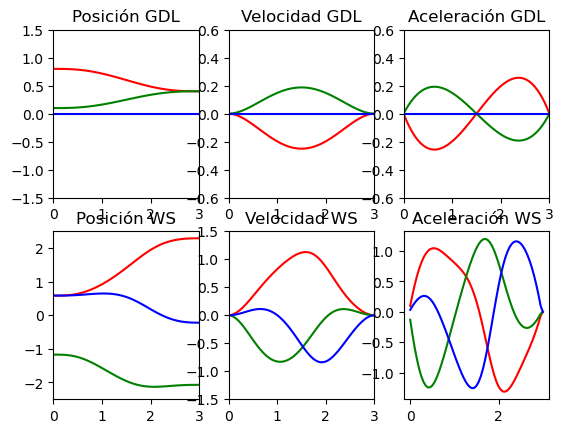

In [44]:
#!/usr/bin/env python3
import rclpy
from rclpy.node import Node
from std_msgs.msg import String
from sympy import *
#from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols

import matplotlib
import matplotlib.pyplot as plt
import numpy

class TrayectoryGenerator():
  def __init__(self, dim = (0.3, 0.3, 0.3), base_dim = (0, 0, 0.1), base_rot = (pi/2, 0, 0)):
    #Parámetros de dimensiones
    self.dim = dim
    self.base_dim = base_dim
    self.base_rot = base_rot
    #Variables para cinemática directa
    self.theta_O_1 = Symbol('theta_O_1')
    self.theta_1_2 = Symbol('theta_1_2')
    self.theta_2_3 = Symbol('theta_2_3')
    #Grados de libertad
    self.x_O_P = Symbol('x_O_P')
    self.z_O_P = Symbol('y_O_P')
    self.theta_O_P = Symbol('theta_O_P')
    #Velocidades
    self.x_O_P_dot = Symbol('x_O_P_dot')
    self.z_O_P_dot = Symbol('y_O_P_dot')
    self.theta_O_P_dot = Symbol('theta_O_P_dot')
    #Transformaciones homogéneas
    T_O_O = self.trans_homo(self.base_dim[0], self.base_dim[1], self.base_dim[2], 
                            self.base_rot[0], self.base_rot[1], self.base_rot[2])
    
    T_O_1 = self.trans_homo(0, 0, 0, 
                            0, 0, self.theta_O_1)
    T_1_2 = self.trans_homo(self.dim[0], 0, 0, 
                            0, 0, self.theta_1_2)
    T_2_3 = self.trans_homo(self.dim[1], 0, 0, 
                            0, 0, self.theta_2_3)
    T_3_P = self.trans_homo(self.dim[2], 0, 0, 
                            0, 0, 0)
    T_O_P = simplify(T_O_O*T_O_1 * T_1_2 * T_2_3 * T_3_P)
    self.xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], 
                          self.theta_O_1 + self.theta_1_2 + self.theta_2_3])
    self.J = Matrix.hstack(diff(self.xi_O_P, self.theta_O_1), 
                           diff(self.xi_O_P, self.theta_1_2), 
                           diff(self.xi_O_P, self.theta_2_3))
    self.J_inv = self.J.inv()
    #print(self.J)
  def trans_homo(self, x, y, z, gamma, beta, alpha):
    T = Matrix([[cos(alpha)*cos(beta), -sin(alpha)*cos(gamma)+sin(beta)*sin(gamma)*cos(alpha), sin(alpha)*sin(gamma)+sin(beta)*cos(alpha)*cos(gamma), x],
         [sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-sin(gamma)*cos(alpha), y],
        [-sin(beta), sin(gamma)*cos(beta), cos(beta)*cos(gamma), z],[0, 0, 0, 1]])
    return T 
  def polinomial_trayectory_generator(self, frec = 20, time = (0, 3), gdl_in = (0.8, 0.1, 0), gdl_fn = (0.4, 0.4, 0)):
    self.frec = frec
    a_0, a_1, a_2, a_3, a_4, a_5, t = symbols('a_0 a_1 a_2 a_3 a_4 a_5 t')
    lam = a_0 + a_1*t + a_2*(t**2) + a_3*(t**3) + a_4*(t**4) + a_5*(t**5)
    lam_dot = diff(lam, t)
    lam_dot_dot = diff(lam_dot, t)
    terms = solve([
      lam.subs(t, time[0]) - 0,
      lam.subs(t, time[1]) - 1,
      lam_dot.subs(t, time[0]) - 0,
      lam_dot.subs(t, time[1]) - 0,
      lam_dot_dot.subs(t, time[0]) - 0,
      lam_dot_dot.subs(t, time[1]) - 0
    ], [a_0, a_1, a_2, a_3, a_4, a_5], dict = True)
    print(terms)
    #Lambda con valores sustituidos
    lam_s = lam.subs(terms[0])
    lam_s_dot = lam_dot.subs(terms[0])
    lam_s_dot_dot = lam_dot_dot.subs(terms[0])
    samples = frec * (time[1] - time[0]) + 1
    dt = 1.0 / frec

    #Creando arreglos para guardar las posiciones de los GDL
    gdl = []
    gdl_dot = []
    gdl_dot_dot = []
    for a in range(samples):
      gdl.append((gdl_in[0] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                  gdl_in[1] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                  gdl_in[2] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot.append((lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot_dot.append((lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
    #Obteniendo posición inicial del ws
    self.xi_desp = self.xi_O_P - Matrix([gdl_in[0], 
                                        gdl_in[1], 
                                        gdl_in[2]])
    """print("Calculando posiciones iniciales")
    q_in = solve([self.xi_desp],
                  [self.theta_O_1, 
                   self.theta_1_2, 
                   self.theta_2_3])
    print("Posiciones iniciales:")
    print(q_in)
    q_in_def = 0
    for i in q_in:
      if i[0]>0:
        q_in_def = i
        break
    """
    q_in_def = (0.585685543457151, 
                -1.17137108691430, 
                0.585685543457151)
    #Calculando velocidad inicial
    self.xi_O_P_dot = Matrix([self.x_O_P_dot,
                              self.z_O_P_dot,
                              self.theta_O_P_dot])
    self.q_O_P_dot = self.J_inv * self.xi_O_P_dot
    #Arreglos para guardar las posiciones del ws
    ws = []
    ws_dot = []
    ws_dot_dot = []
    #Agregando posición inicial
    ws.append(q_in_def)
    #Agregando velocidad inicial
    q_dot_in = self.q_O_P_dot.subs({
      self.x_O_P_dot:     gdl_dot[0][0],
      self.z_O_P_dot:     gdl_dot[0][1],
      self.theta_O_P_dot: gdl_dot[0][2],
      self.theta_O_1: ws[0][0],
      self.theta_1_2: ws[0][1],
      self.theta_2_3: ws[0][2]})
    ws_dot.append(q_dot_in)
    #Calculando todos los valores por cinemática inversa
    for a in range(samples - 1):
      #Posición 
      ws.append((ws[a][0] + ws_dot[a][0] * dt,
                 ws[a][1] + ws_dot[a][1] * dt,
                 ws[a][2] + ws_dot[a][2] * dt))
      #Velocidad
      q_dot_iter = self.q_O_P_dot.subs({
                                      self.x_O_P_dot:     gdl_dot[a+1][0],
                                      self.z_O_P_dot:     gdl_dot[a+1][1],
                                      self.theta_O_P_dot: gdl_dot[a+1][2],
                                      self.theta_O_1: ws[a+1][0],
                                      self.theta_1_2: ws[a+1][1],
                                      self.theta_2_3: ws[a+1][2]})
      ws_dot.append(q_dot_iter)
      #Aceleración
      ws_dot_dot.append((
                    (ws_dot[a+1][0]-ws_dot[a][0]) / dt,
                    (ws_dot[a+1][1]-ws_dot[a][1]) / dt,
                    (ws_dot[a+1][2]-ws_dot[a][2]) / dt))
      #print("Iteración: " + str(a))
    #Aceleración final
    ws_dot_dot.append((0,0,0))
    self.gdl = gdl
    self.gdl_dot = gdl_dot
    self.gdl_dot_dot = gdl_dot_dot
    self.ws = ws
    self.ws_dot = ws_dot
    self.ws_dot_dot = ws_dot_dot
  def trayectory_graphics(self):
    #Grados de libertad
    gdl_t = []
    gdl_p_0 = []
    gdl_p_1 = []
    gdl_p_2 = []
    gdl_v_0 = []
    gdl_v_1 = []
    gdl_v_2 = []
    gdl_a_0 = []
    gdl_a_1 = []
    gdl_a_2 = []
    #Espacio de trabajo
    ws_t = []
    ws_p_0 = []
    ws_p_1 = []
    ws_p_2 = []
    ws_v_0 = []
    ws_v_1 = []
    ws_v_2 = []
    ws_a_0 = []
    ws_a_1 = []
    ws_a_2 = []

    for i in range(len(self.gdl)):
      gdl_t.append(float(i) / self.frec)
      gdl_p_0.append(self.gdl[i][0])
      gdl_p_1.append(self.gdl[i][1])
      gdl_p_2.append(self.gdl[i][2])
      gdl_v_0.append(self.gdl_dot[i][0])
      gdl_v_1.append(self.gdl_dot[i][1])
      gdl_v_2.append(self.gdl_dot[i][2])
      gdl_a_0.append(self.gdl_dot_dot[i][0])
      gdl_a_1.append(self.gdl_dot_dot[i][1])
      gdl_a_2.append(self.gdl_dot_dot[i][2])
    for i in range(len(self.ws)):
      ws_t.append(float(i) / self.frec)
      ws_p_0.append(self.ws[i][0])
      ws_p_1.append(self.ws[i][1])
      ws_p_2.append(self.ws[i][2])
      ws_v_0.append(self.ws_dot[i][0])
      ws_v_1.append(self.ws_dot[i][1])
      ws_v_2.append(self.ws_dot[i][2])
      ws_a_0.append(self.ws_dot_dot[i][0])
      ws_a_1.append(self.ws_dot_dot[i][1])
      ws_a_2.append(self.ws_dot_dot[i][2])
    fig, ((gdl_plot, gdl_dot_plot, gdl_dot_dot_plot), 
          (ws_plot, ws_dot_plot, ws_dot_dot_plot),
          ) = plt.subplots(nrows = 2, ncols = 3)    
    #Gráficas GDL
    gdl_plot.set_title("Posición GDL")
    gdl_plot.axis((0, 3, -1.5, 1.5))
    gdl_plot.plot(gdl_t, gdl_p_0, color = "RED")
    gdl_plot.plot(gdl_t, gdl_p_1, color = "GREEN")
    gdl_plot.plot(gdl_t, gdl_p_2, color = "BLUE")
    gdl_dot_plot.set_title("Velocidad GDL")
    gdl_dot_plot.axis((0, 3, -0.6, 0.6))
    gdl_dot_plot.plot(gdl_t, gdl_v_0, color = "RED")
    gdl_dot_plot.plot(gdl_t, gdl_v_1, color = "GREEN")
    gdl_dot_plot.plot(gdl_t, gdl_v_2, color = "BLUE")
    gdl_dot_dot_plot.set_title("Aceleración GDL")
    gdl_dot_dot_plot.axis((0, 3, -0.6, 0.6))
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_0, color = "RED")
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_1, color = "GREEN")
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_2, color = "BLUE")
    #Gráficas WS
    ws_plot.set_title("Posición WS")
    ws_plot.axis((0, 3, -2.5, 2.5))
    ws_plot.plot(ws_t, ws_p_0, color = "RED")
    ws_plot.plot(ws_t, ws_p_1, color = "GREEN")
    ws_plot.plot(ws_t, ws_p_2, color = "BLUE")

    ws_dot_plot.set_title("Velocidad WS")
    ws_dot_plot.axis((0, 3, -1.5, 1.5))
    ws_dot_plot.plot(ws_t, ws_v_0, color = "RED")
    ws_dot_plot.plot(ws_t, ws_v_1, color = "GREEN")
    ws_dot_plot.plot(ws_t, ws_v_2, color = "BLUE")
    ws_dot_dot_plot.set_title("Aceleración WS")
    ws_dot_plot.axis((0, 3, -1.5, 1.5))
    ws_dot_dot_plot.plot(ws_t, ws_a_0, color = "RED")
    ws_dot_dot_plot.plot(ws_t, ws_a_1, color = "GREEN")
    ws_dot_dot_plot.plot(ws_t, ws_a_2, color = "BLUE")
    plt.show()

def main():
  trayectory_gen = TrayectoryGenerator()
  trayectory_gen.polinomial_trayectory_generator()
  trayectory_gen.trayectory_graphics()
  """rclpy.init()
  node = ROSSuscriberNode()
  rclpy.spin(node)
  rclpy.shutdown()"""

if __name__ == "__main__":
  main()

### 5. Github
Para terminar, crear un repositorio en línea en gihub, donde se subirán los archivos de la práctica. 
Se recomienda primero crear el repositorio en línea, clonarlo en el ordenador y después incluir los archivos de la práctica. 
Para utilizar el repositorio para todas las prácticas posteriores, se recomienda usar la siguiente estructura de archivos:
~~~ bash
repositorio_practicas/
├── practica_2
│   ├── imagenes
│   │   └── P2_IM1.png
│   └── Practica_2.ipynb
└── README.md
~~~
Dentro del archivo README.md (Creado de forma automática en el repositorio en línea), colocar los nombres de los integrantes del equipo.

## Análisis de resultados

¿Qué utilidad tiene el modelo de cinemática inversa de un robot?
> RESPUESTA:

En primera permite el cálculo de las posiciones, velocidades y aceleraciones necesarias de cada articulación para que el efector final (la punta del robot) alcance una posición o siga una trayectoria específica en su espacio de trabajo, es decir, dada una posición o trayectoria deseada del efector en el espacio cartesiano (como un punto en una línea recta o una figura circular), la cinemática inversa permite determinar los valores de los ángulos o desplazamientos que cada articulación debe adoptar para lograrlo.

Entre algunos puntos más especifícos se encuentran:

Permite el control de trayectorias complejas: Al conocer las posiciones articulares necesarias, el robot puede realizar trayectorias de trabajo precisas, como pintar una línea, soldar o manipular objetos en lugares específicos.

Facilita la traducción del espacio de trabajo al espacio articular: Dado que las trayectorias suelen definirse en el espacio de trabajo, es esencial convertir esas coordenadas a las posiciones de articulación necesarias para realizarlas.

Asegura un desempeño óptimo en aplicaciones industriales y de precisión: La cinemática inversa permite ajustar y optimizar los movimientos, mejorando la precisión y la eficiencia del robot en tareas específicas.

¿Controlar las condiciones iniciales y finales de la trayectoria del efector final tiene un efecto en las condiciones inicial y final de las juntas?
> RESPUESTA:

Si, ya que, definir una trayectoria específica para el efector final en el espacio de trabajo (como posición, velocidad y aceleración deseadas al inicio y final), son condiciones que deben traducirse a movimientos en cada articulación para que el robot pueda alcanzar y mantener esa trayectoria. Este proceso se logra mediante la cinemática inversa, que calcula los ángulos o desplazamientos articulares necesarios, es decir, que todos estos calculos de ángulos y desplazamientos cambiarían porque el movimiento al final no es el mismo.

¿Qué utilidad tiene el uso de un repositorio en línea para código?
> RESPUESTA:


Usar Git y en especial GitHub nos ayuda a estos puntos:

Control de versiones: Permite llevar un registro de los cambios realizados en el código a lo largo del tiempo. Esto facilita revertir a versiones anteriores si es necesario y entender cómo ha evolucionado el proyecto.

Colaboración en equipo: Múltiples personas pueden trabajar en el mismo proyecto simultáneamente. Cada miembro puede aportar modificaciones sin afectar el trabajo de los demás, y los cambios se integran de manera organizada.

Respaldo y seguridad: Al almacenar el código en la nube, los archivos están protegidos contra pérdida local de datos. Esto garantiza un acceso seguro al proyecto desde cualquier lugar y dispositivo con conexión a internet.

Documentación y trazabilidad en cambios: Se puede documentar cada cambio y guardar detalles sobre qué se cambió y por qué. Esto facilita la resolución de problemas y el aprendizaje de otros desarrolladores al analizar el historial del proyecto.




## Conclusiones

En esta sección deberan escribir las conclusiones de la práctica con base en el objetivo planteado y las metas que se deban cumplir para su realización.

## Bibliografía 

En caso de usarse, se deben hacer referencia a la información implementada en formato ieee

M. H. Ordoñez, M. B. Ortiz Moctezuma, C. A. Calles Arriaga, y J. C. Rodríguez Portillo, Robótica: Análisis, modelado, control e implementación. Ciudad de México, omnia science, 2015.
